In [1]:
import numpy as np
import pandas as pd
import psutil
from pathlib import Path

from matplotlib import pyplot as plt

import os, random, gc, glob
import re, time, json

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from ppca import PPCA

from scipy.linalg import orth

import geopandas as gpd
import plotly_express as px

In [2]:
process = psutil.Process(os.getpid())
print('start', process.memory_info().rss)

start 151556096


In [3]:
feature_data = pd.read_csv('features_single_last100.csv')
feature_data = feature_data.dropna()
feature_data = feature_data.reset_index(drop=True)

In [4]:
# Copy feature_data for model training purposes
X = feature_data.copy()

# Sort X by names and filter out bottom 80% of rows by bird name count
X_names_sort = X.groupby('bird name').size().sort_values(ascending=False)
good_names = X_names_sort[:int(len(X_names_sort)/20+1)].index.values
X_new = X[X['bird name'].str.contains('|'.join(good_names))]

# encode corresponding categorical labels with numeric values
y = X_new['bird name'].astype('category').cat.codes

# Delete last two columns (not feature-related)
X_filt = X_new.drop(columns=['Unnamed: 0','bird name','filename'])

# Sort X by names and filter out bottom 80% of columns by variance
X_filt_var_sort = X_filt.var().sort_values(ascending=False)
good_cols = X_filt_var_sort[:int(len(X_filt_var_sort)*0.8+1)].index.values
X_filt_high_var = X_filt[good_cols]
#X_filt_high_var

# Normalize columns of X (from feature_data)
X_norm = pd.DataFrame.from_records(preprocessing.normalize(X_filt_high_var, axis = 0))

In [5]:
# Perform PCA on X_norm to reduce dimensions—i.e. reduce model complexity
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X_norm)

X_pca_pd = pd.DataFrame(X_pca)

# Perform factor analysis on X_norm to reduce dimensions
fact_an = FactorAnalysis(n_components=40, random_state=44)
X_fact_an = fact_an.fit_transform(X_norm)

X_fact_an_pd = pd.DataFrame(X_fact_an)

print('now', process.memory_info().rss)
#X_pca_pd
#X_fact_an_pd

now 171032576


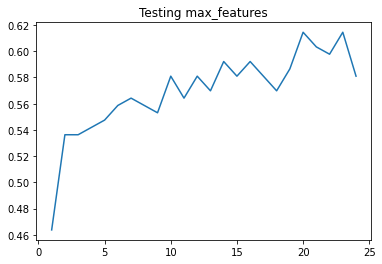

Max score of 0.6145251396648045 for 19 max features.


In [6]:
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca_pd, y, random_state=44)

scores = []
for j in range(1,25):
    model = RandomForestClassifier(max_features = j, max_depth=None, min_samples_split = 2,
                                   n_estimators = 500, random_state = 44)
    model.fit(X_pca_train,y_train);
    scores = scores + [model.score(X_pca_test,y_test)]
plt.plot(range(1,25),scores)
plt.title('Testing max_features')
plt.show()
#print(scores)
print("Max score of",np.amax(scores),"for",np.argmax(scores),"max features.")

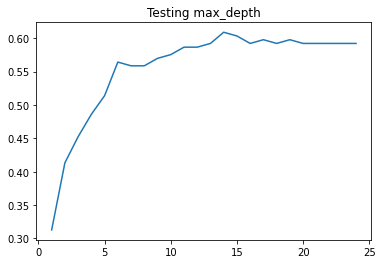

Max score of 0.6089385474860335 for depth 13 .


In [7]:
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca_pd, y, random_state=44)

scores = []
for j in range(1,25):
    model = RandomForestClassifier(max_features = 16, max_depth=j, min_samples_split = 2,
                                   n_estimators = 500, random_state = 44)
    model.fit(X_pca_train,y_train);
    scores = scores + [model.score(X_pca_test,y_test)]
plt.plot(range(1,25),scores)
plt.title('Testing max_depth')
plt.show()
#print(scores)
print("Max score of",np.amax(scores),"for depth",np.argmax(scores),".")

In [ ]:
X_fact_an_train, X_fact_an_test, y_train, y_test = train_test_split(X_fact_an_pd, y, random_state=44)

scores = []
for j in range(1,25):
    model = RandomForestClassifier(max_features = j, max_depth=None, min_samples_split = 2,
                                   n_estimators = 500, random_state = 44)
    model.fit(X_fact_an_train,y_train);
    scores = scores + [model.score(X_fact_an_test,y_test)]
plt.plot(range(1,25),scores)
plt.title('Testing max_features')
plt.show()
#print(scores)
print("Max score of",np.amax(scores),"for",np.argmax(scores),"max features.")

In [ ]:
X_fact_an_train, X_fact_an_test, y_train, y_test = train_test_split(X_fact_an_pd, y, random_state=44)

scores = []
for j in range(1,25):
    model = RandomForestClassifier(max_features = 5, max_depth=j, min_samples_split = 2,
                                   n_estimators = 500, random_state = 44)
    model.fit(X_fact_an_train,y_train);
    scores = scores + [model.score(X_fact_an_test,y_test)]
plt.plot(range(1,25),scores)
plt.title('Testing max_depth')
plt.show()
#print(scores)
print("Max score of",np.amax(scores),"for depth",np.argmax(scores),".")